# Multi step feed-forward neural network model (vector output approach)

In this notebook, we demonstrate how to:
- prepare time series data for training a feed-forward neural network forecasting model
- get data in the required shape for the keras API
- implement a feed-forward NN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses recent values of temperature and load as the model input. The model will be trained to output a vector, the elements of which are ordered predictions for future time steps.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

Please run this notebook after completing 0_data_setup notebook.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from collections import UserDict
from common.utils import *
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load data into Pandas dataframe

In [10]:
energy = load_data('data')
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [1]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

## Data preparation - training set

For this example, we will set T=6. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of T=6 was arbitrary but should be selected through experimentation.  

HORIZON=3 specifies that we have a forecasting horizon of 3 (t+1, t+2, t+3)

![multistep forecast](./images/multistep_forecast.png "multistep forecast")

In [11]:
T = 6
HORIZON = 3

In [12]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

In [13]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **target** name of the target column
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency (default 'H' - hourly)
- **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)

In [14]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [15]:
train_inputs.dataframe.head(3)

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39

In [16]:
X_train = train_inputs.dataframe.as_matrix()[:,HORIZON:]
X_train.shape

(23368, 12)

In [17]:
train_inputs['target']

array([[0.18, 0.23, 0.29],
       [0.23, 0.29, 0.35],
       [0.29, 0.35, 0.37],
       ...,
       [0.61, 0.58, 0.51],
       [0.58, 0.51, 0.43],
       [0.51, 0.43, 0.34]])

## Data preparation - validation set

Construct validation set (keeping W hours from the training set in order to construct initial features)

In [18]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)
X_valid = valid_inputs.dataframe.as_matrix()[:,HORIZON:]
X_valid.shape

(1461, 12)

## Implement feed-forward neural network

We implement feed-forward neural network with the following structure:

![One step univariate FFNN model](./images/ff_multi_step_vector_output.png "One step univariate FFNN model")

In [19]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [20]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

In [21]:
model = Sequential()
model.add(Dense(LATENT_DIM, activation="relu", input_shape=(2*T,)))
model.add(Dense(HORIZON))

In [22]:
model.compile(optimizer='RMSprop', loss='mse')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


Specify the early stopping criteria. We monitor the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by min_delta after patience epochs, we stop the training.

In [24]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [25]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [26]:
history = model.fit(X_train,
                    train_inputs['target'],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, valid_inputs['target']),
                    callbacks=[earlystop, best_val],
                    verbose=1)

Train on 23368 samples, validate on 1461 samples
Epoch 1/50
23368/23368 [==============================] - 1s 54us/step - loss: 0.0547 - val_loss: 0.0109
Epoch 2/50
23368/23368 [==============================] - 1s 40us/step - loss: 0.0092 - val_loss: 0.0076
Epoch 3/50
23368/23368 [==============================] - 1s 43us/step - loss: 0.0072 - val_loss: 0.0067
Epoch 4/50
23368/23368 [==============================] - 1s 41us/step - loss: 0.0060 - val_loss: 0.0059
Epoch 5/50
23368/23368 [==============================] - 1s 42us/step - loss: 0.0054 - val_loss: 0.0050
Epoch 6/50
23368/23368 [==============================] - 1s 44us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 7/50
23368/23368 [==============================] - 1s 39us/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/50
23368/23368 [==============================] - 1s 41us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 9/50
23368/23368 [==============================] - 1s 56us/step - loss: 0.0045 - val_loss: 0.0042
Epoch 

## Evaluate the model

Load the model with the smallest mape

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

In [28]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)
X_test = test_inputs.dataframe.as_matrix()[:,HORIZON:]
X_test.shape

(1456, 12)

In [29]:
predictions = model.predict(X_test)

In [30]:
predictions

array([[0.22, 0.28, 0.33],
       [0.31, 0.36, 0.41],
       [0.35, 0.4 , 0.45],
       ...,
       [0.62, 0.58, 0.53],
       [0.56, 0.48, 0.41],
       [0.51, 0.44, 0.38]], dtype=float32)

In [31]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,704.70","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,972.48","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,130.06","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,259.95","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,412.38","3,436.00"


Compute MAPE for each forecast horizon

In [32]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.04
t+3   0.06
Name: APE, dtype: float64

Compute MAPE across all predictions

In [33]:
mape(eval_df['prediction'], eval_df['actual'])

0.03829611211316449

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

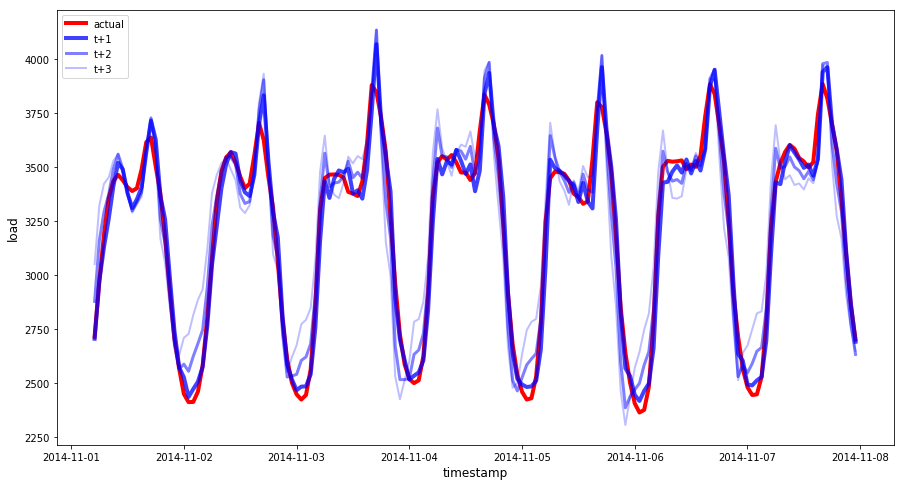

In [34]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

clean up model files

In [ ]:
for m in glob('model_*.h5'):
    os.remove(m)